## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
import joblib
from tqdm import tqdm

## Reading Data

In [2]:
# 1. Load and preprocess data
df = pd.read_parquet('../data/raw/yellow_tripdata_2023-01.parquet')
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 7200)]

## Fill NA Values

In [3]:
for col in ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'airport_fee']:
    df[col] = df[col].fillna(df[col].mean())

# Fill categorical column with mode
for col in ['store_and_fwd_flag']:
    df[col] = df[col].fillna(df[col].mode()[0])

## Feature Engineering

In [4]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['is_weekend'] = df['pickup_weekday'].isin([5, 6]).astype(int)
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['month'] = df['tpep_pickup_datetime'].dt.month
df['is_peak'] = ((df['pickup_hour'].between(7,9)) | (df['pickup_hour'].between(16,18))).astype(int)

def time_of_day(hour):
    if hour < 6: return 'night'
    elif hour < 12: return 'morning'
    elif hour < 18: return 'afternoon'
    else: return 'evening'
df['time_of_day'] = df['pickup_hour'].apply(time_of_day)

categorical_cols = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
    'PULocationID', 'DOLocationID', 'time_of_day'
]
numerical_cols = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge',
    'pickup_hour', 'pickup_weekday', 'is_weekend', 'pickup_day', 'month', 'is_peak', 'manhattan_dist'
]
numerical_cols = [col for col in numerical_cols if col in df.columns]

# Label encode categoricals
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Prepare data
X = df[categorical_cols + numerical_cols]
y = df['trip_duration'].values.astype(np.float32)

## Train Test Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. PyTorch Neural Network

In [6]:
# ========== PyTorch Neural Network ==========
class TaxiDataset(Dataset):
    def __init__(self, X, y, categorical_cols, numerical_cols):
        self.X_cat = X[categorical_cols].values.astype(np.int64)
        self.X_num = X[numerical_cols].values.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

train_ds = TaxiDataset(X_train, y_train, categorical_cols, numerical_cols)
val_ds = TaxiDataset(X_val, y_val, categorical_cols, numerical_cols)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=2048, shuffle=False, num_workers=2, pin_memory=True)

cat_dims = [int(df[col].nunique()) for col in categorical_cols]
emb_dims = [(x, min(50, (x+1)//2)) for x in cat_dims]

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Print CUDA info for debugging
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

class TaxiNet(nn.Module):
    def __init__(self, emb_dims, n_num):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        emb_dim_sum = sum([y for x, y in emb_dims])
        self.fc = nn.Sequential(
            nn.Linear(emb_dim_sum + n_num, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_num], 1)
        return self.fc(x).squeeze(1)

# Set device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TaxiNet(emb_dims, len(numerical_cols)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.MSELoss()

# Use a reasonable batch size and num_workers=0 for debugging
BATCH_SIZE = 1024
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Training loop with tqdm and early stopping
best_r2 = -np.inf
patience, patience_counter = 20, 0
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for x_cat, x_num, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x_cat, x_num, y_batch = x_cat.to(device), x_num.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_cat, x_num)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for x_cat, x_num, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            preds = model(x_cat, x_num).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(y_batch.numpy())
    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    val_r2 = r2_score(val_targets, val_preds)
    print(f"Epoch {epoch+1:02d} | Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse:.2f} | Val R2: {val_r2:.4f}")
    if val_r2 > best_r2:
        best_r2 = val_r2
        patience_counter = 0
        torch.save(model.state_dict(), 'best_taxi_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and get predictions for stacking
model.load_state_dict(torch.load('best_taxi_model.pt'))
model.eval()

def get_nn_preds(X_df):
    ds = TaxiDataset(X_df, np.zeros(len(X_df)), categorical_cols, numerical_cols)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    preds = []
    with torch.no_grad():
        for x_cat, x_num, _ in tqdm(dl, desc="Predicting"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            batch_preds = model(x_cat, x_num).cpu().numpy()
            preds.append(batch_preds)
    return np.concatenate(preds)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4050 Laptop GPU


Epoch 1 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 166.83it/s]


Epoch 01 | Train Loss: 272810.2996 | Val RMSE: 220.71 | Val R2: 0.8867


Epoch 2 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 165.31it/s]


Epoch 02 | Train Loss: 39512.2988 | Val RMSE: 1379.83 | Val R2: -3.4267


Epoch 3 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 165.76it/s]


Epoch 03 | Train Loss: 37536.0432 | Val RMSE: 921.92 | Val R2: -0.9761


Epoch 4 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 168.34it/s]


Epoch 04 | Train Loss: 36167.4651 | Val RMSE: 699.77 | Val R2: -0.1385


Epoch 5 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 166.12it/s]


Epoch 05 | Train Loss: 33471.8467 | Val RMSE: 550.04 | Val R2: 0.2966


Epoch 6 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 165.41it/s]


Epoch 06 | Train Loss: 31097.6951 | Val RMSE: 369.08 | Val R2: 0.6833


Epoch 7 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 166.02it/s]


Epoch 07 | Train Loss: 29563.7304 | Val RMSE: 1164.01 | Val R2: -2.1502


Epoch 8 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 164.39it/s]


Epoch 08 | Train Loss: 28873.7101 | Val RMSE: 336.16 | Val R2: 0.7373


Epoch 9 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 164.86it/s]


Epoch 09 | Train Loss: 28289.8356 | Val RMSE: 202.52 | Val R2: 0.9046


Epoch 10 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 168.10it/s]


Epoch 10 | Train Loss: 27978.8469 | Val RMSE: 214.67 | Val R2: 0.8929


Epoch 11 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 165.53it/s]


Epoch 11 | Train Loss: 27725.7087 | Val RMSE: 195.33 | Val R2: 0.9113


Epoch 12 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 163.34it/s]


Epoch 12 | Train Loss: 27536.9409 | Val RMSE: 239.65 | Val R2: 0.8665


Epoch 13 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 159.64it/s]


Epoch 13 | Train Loss: 27292.8622 | Val RMSE: 221.05 | Val R2: 0.8864


Epoch 14 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 165.76it/s]


Epoch 14 | Train Loss: 27443.5758 | Val RMSE: 1031.38 | Val R2: -1.4733


Epoch 15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 167.65it/s]


Epoch 15 | Train Loss: 27197.0947 | Val RMSE: 442.14 | Val R2: 0.5455


Epoch 16 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 162.21it/s]


Epoch 16 | Train Loss: 27118.9157 | Val RMSE: 293.63 | Val R2: 0.7995


Epoch 17 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 171.37it/s]


Epoch 17 | Train Loss: 26950.9844 | Val RMSE: 681.24 | Val R2: -0.0790


Epoch 18 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 166.20it/s]


Epoch 18 | Train Loss: 26980.2743 | Val RMSE: 551.75 | Val R2: 0.2922


Epoch 19 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 168.86it/s]


Epoch 19 | Train Loss: 26905.6642 | Val RMSE: 271.21 | Val R2: 0.8290


Epoch 20 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 169.33it/s]


Epoch 20 | Train Loss: 26912.3391 | Val RMSE: 431.02 | Val R2: 0.5681


Epoch 21 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 161.93it/s]


Epoch 21 | Train Loss: 26676.5500 | Val RMSE: 207.10 | Val R2: 0.9003


Epoch 22 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 169.72it/s]


Epoch 22 | Train Loss: 26669.1973 | Val RMSE: 408.31 | Val R2: 0.6124


Epoch 23 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 166.11it/s]


Epoch 23 | Train Loss: 26643.4715 | Val RMSE: 2540.34 | Val R2: -14.0042


Epoch 24 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 170.78it/s]


Epoch 24 | Train Loss: 26572.0763 | Val RMSE: 1094.34 | Val R2: -1.7844


Epoch 25 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 168.62it/s]


Epoch 25 | Train Loss: 26573.8424 | Val RMSE: 715.11 | Val R2: -0.1890


Epoch 26 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 160.00it/s]


Epoch 26 | Train Loss: 26551.8674 | Val RMSE: 441.91 | Val R2: 0.5459


Epoch 27 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 172.28it/s]


Epoch 27 | Train Loss: 26415.0641 | Val RMSE: 210.95 | Val R2: 0.8965


Epoch 28 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 170.03it/s]


Epoch 28 | Train Loss: 26445.9795 | Val RMSE: 253.21 | Val R2: 0.8509


Epoch 29 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 172.71it/s]


Epoch 29 | Train Loss: 26415.9823 | Val RMSE: 217.87 | Val R2: 0.8896


Epoch 30 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 166.50it/s]


Epoch 30 | Train Loss: 26383.8196 | Val RMSE: 585.48 | Val R2: 0.2030


Epoch 31 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 170.54it/s]

Epoch 31 | Train Loss: 26357.9194 | Val RMSE: 649.31 | Val R2: 0.0198
Early stopping triggered.



C:\Users\Sriram\AppData\Local\Temp\ipykernel_55352\782266870.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_taxi_model.pt'))


## 1. PyTorch Neural Network Evaluation

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# After training and loading best model weights
model.load_state_dict(torch.load('best_taxi_model.pt'))
model.eval()

# Get predictions on validation set
val_preds = []
val_targets = []
with torch.no_grad():
    for x_cat, x_num, y_batch in val_loader:
        x_cat, x_num = x_cat.to(device), x_num.to(device)
        preds = model(x_cat, x_num).cpu().numpy()
        val_preds.append(preds)
        val_targets.append(y_batch.numpy())
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Remove any NaNs just in case
mask = ~np.isnan(val_preds) & ~np.isnan(val_targets)
val_preds = val_preds[mask]
val_targets = val_targets[mask]

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
r2 = r2_score(val_targets, val_preds)
print(f"PyTorch NN - RMSE: {rmse:.2f}, R²: {r2:.4f}")


C:\Users\Sriram\AppData\Local\Temp\ipykernel_55352\380585576.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_taxi_model.pt'))


PyTorch NN - RMSE: 195.33, R²: 0.9113


## XGBoost

In [9]:
# ========== XGBoost with GPU ==========
xgb_model = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=20
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:51:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:51:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_pred = xgb_model.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Compute R² score
r2 = r2_score(y_val, y_pred)

print(f"XGBoost (GPU) - RMSE: {rmse:.2f}, R²: {r2:.4f}")

XGBoost (GPU) - RMSE: 146.63, R²: 0.9500


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [21:51:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:51:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

 

## LightGBM

In [11]:
# ========== LightGBM with GPU ==========
lgb_model = lgb.LGBMRegressor(
    device='gpu',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=500,
    min_child_samples=20,
    early_stopping_rounds=20,
    random_state=42,
)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 2424060, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (27.74 MB) transferred to GPU in 0.030023 secs. 1 sparse feature groups
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Start training from score 875.356121
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 24297.2

LGBMRegressor(device='gpu', early_stopping_rounds=20, learning_rate=0.05,
              n_estimators=500, random_state=42)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_pred = lgb_model.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Compute R² score
r2 = r2_score(y_val, y_pred)

print(f"LGB_Model (GPU) - RMSE: {rmse:.2f}, R²: {r2:.4f}")

LGB_Model (GPU) - RMSE: 155.88, R²: 0.9435


## Plot

C:\Users\Sriram\AppData\Local\Temp\ipykernel_55352\2628165601.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['y_val'], label='Actual (y_val)', shade=True)
C:\Users\Sriram\AppData\Local\Temp\ipykernel_55352\2628165601.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['y_pred'], label='Predicted (y_pred)', shade=True)


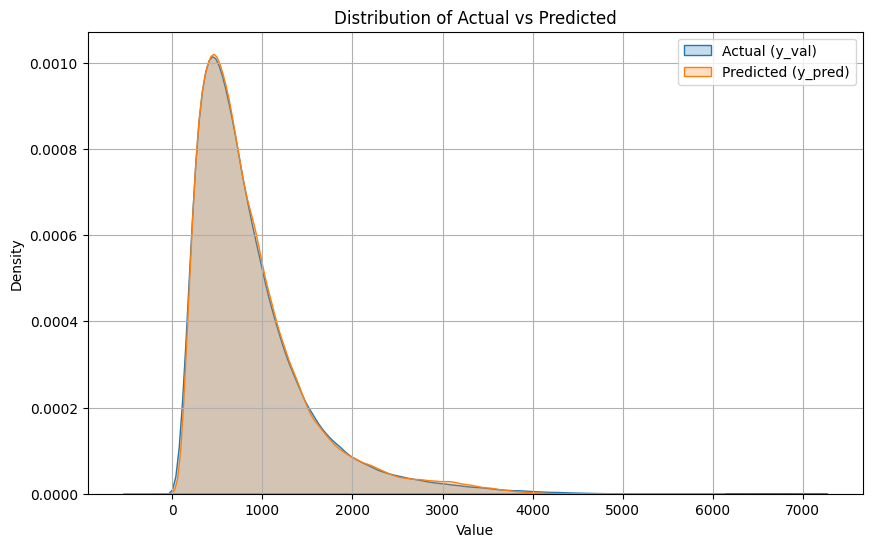

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_val and y_pred are lists, Series, or arrays
df = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})

plt.figure(figsize=(10, 6))
sns.kdeplot(df['y_val'], label='Actual (y_val)', shade=True)
sns.kdeplot(df['y_pred'], label='Predicted (y_pred)', shade=True)
plt.title('Distribution of Actual vs Predicted')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


## TabNet Regressor

In [14]:
from pytorch_tabnet.tab_model import TabNetRegressor

tabnet = TabNetRegressor(device_name='cuda' if torch.cuda.is_available() else 'cpu')
tabnet.fit(
    X_train.values, y_train.reshape(-1, 1),
    eval_set=[(X_val.values, y_val.reshape(-1, 1))],
    eval_metric=['rmse'],
    max_epochs=20,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0
)
tabnet_pred = tabnet.predict(X_val.values).squeeze()
print(f"TabNet RMSE: {np.sqrt(mean_squared_error(y_val, tabnet_pred)):.2f}, R²: {r2_score(y_val, tabnet_pred):.4f}")


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 94662.62751| val_0_rmse: 451.44665|  0:01:34s
epoch 1  | loss: 37360.98076| val_0_rmse: 500.14762|  0:03:03s
epoch 2  | loss: 35678.4722| val_0_rmse: 525.99275|  0:04:37s
epoch 3  | loss: 34427.55769| val_0_rmse: 410.25369|  0:06:18s
epoch 4  | loss: 33619.74903| val_0_rmse: 486.03792|  0:07:53s
epoch 5  | loss: 33107.3023| val_0_rmse: 451.52838|  0:09:29s
epoch 6  | loss: 32718.9395| val_0_rmse: 457.33479|  0:11:06s
epoch 7  | loss: 32355.39965| val_0_rmse: 451.68865|  0:12:47s
epoch 8  | loss: 32061.71177| val_0_rmse: 498.66986|  0:14:24s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 410.25369


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet RMSE: 410.25, R²: 0.6087


## Ridge, Lasso, ElasticNet Regressor

In [15]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_val)
print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_val, ridge_pred)):.2f}, R²: {r2_score(y_val, ridge_pred):.4f}")

# Lasso Regression
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_val)
print(f"Lasso RMSE: {np.sqrt(mean_squared_error(y_val, lasso_pred)):.2f}, R²: {r2_score(y_val, lasso_pred):.4f}")

# ElasticNet Regression
enet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
enet.fit(X_train, y_train)
enet_pred = enet.predict(X_val)
print(f"ElasticNet RMSE: {np.sqrt(mean_squared_error(y_val, enet_pred)):.2f}, R²: {r2_score(y_val, enet_pred):.4f}")


Ridge RMSE: 358.04, R²: 0.7019
Lasso RMSE: 358.00, R²: 0.7020
ElasticNet RMSE: 349.55, R²: 0.7159
